##Install Libraries

In [ ]:
!git --version

git version 2.17.1


In [ ]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install audiolazy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121 kB 4.0 MB/s 


##Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import scipy
import seaborn
import librosa
import audiolazy
import sklearn
import os
import glob
import shutil

import scipy.signal as sig
from audiolazy import lazy_lpc
from itertools import cycle
import warnings
import sys

# ignore warnings 
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

##Data Preparation

In [94]:
# Create variable for raw dataset's path
#dtsets1 = '/content/drive/MyDrive/Dataset TA/NewDataPrimer'

dtsets = '/content/drive/MyDrive/DataSpeechs'
type_emotions = ['bahagia', 'kecewa', 'marah', 'sedih']  # Type of emotion to be classified

In [95]:
print(os.listdir(dtsets))

['Salman', 'Aka', 'Tasya', 'Syahri', 'Erzal', 'Sabda', 'Febby', 'Sarah', 'Citra', 'Raina']


In [96]:
'''
Because the dataset used has not been separated according to the type of emotion and the model used is Unsupervised Learning,
it is necessary to separate it according to the type of emotion first.
'''

# Create list to store emotion and path
emotions = []
paths = []

for foldername in sorted(os.listdir(dtsets)):
  folder = os.path.join(dtsets, foldername)
  #print(folder)

  i = 0   # Variable for the process of separation of emotions 
  for filename in sorted(os.listdir(folder)):
    #print(filename)
    file_path = os.path.join(folder, filename)
    #print(file_path)
    
    # The process of separation of emotions
    if i <= 9:
      emotions.append('bahagia')
      paths.append(file_path)
    elif i in range(10, 20):
      emotions.append('marah')
      paths.append(file_path)
    elif i in range(20, 30):
      emotions.append('kecewa')
      paths.append(file_path)
    else:
      emotions.append('sedih')
      paths.append(file_path)
    
    # Increase the value of i when each one of the loop processes is finished
    i += 1

In [97]:
dtsets_df = pd.DataFrame(emotions, columns= ['labels'])
dtsets_df = pd.concat([dtsets_df, pd.DataFrame(paths, columns = ['path'])], axis = 1)

dtsets_df.labels.value_counts()

bahagia    100
marah      100
kecewa     100
sedih      100
Name: labels, dtype: int64

In [98]:
dtsets_df.head()

,labels,path
0,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
1,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
2,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
3,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
4,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...


In [8]:
dtsets_df.to_csv("Data_path.csv", index=False)

###Data Exploration
<p align="justify"> In this section, exploratory data will be carried out to see how the conditions of the dataset that we will use are. We will plot 1 or 2 speech data randomly for each type of emotion. This is done to get a feel for what kind of data we will use. For example, does the data contain a lot of noise? Is the pronunciation clear? etc. If the data we use is difficult for humans to interpret, of course the model will also be difficult to do. </p>

In [9]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import seaborn as sns

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


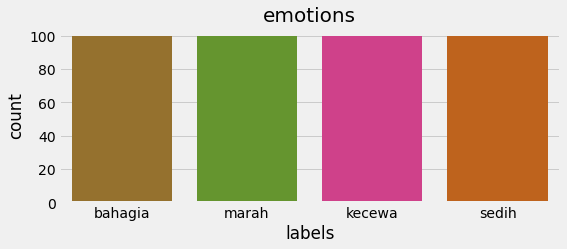

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8, 3)
sns.countplot(dtsets_df['labels'], palette = 'Dark2_r')
plt.title('emotions', fontsize = 20)
plt.show()

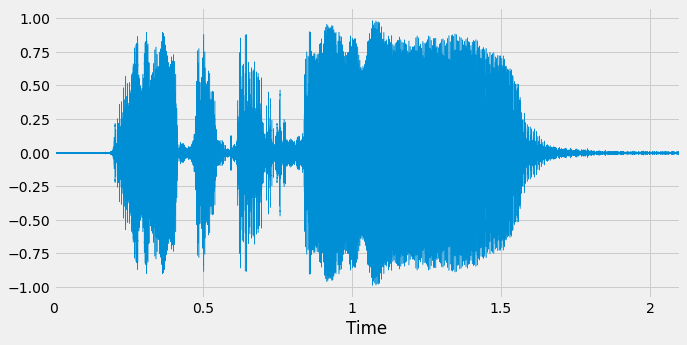

In [ ]:
'''
Let's now look at some sample data for each emotion
to get an idea of the quality of the data to be used
'''

# Use Librosa library display and play sample speech
# This sample is for Angry emotion
fname = dtsets_df._get_value(10, 'path')
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

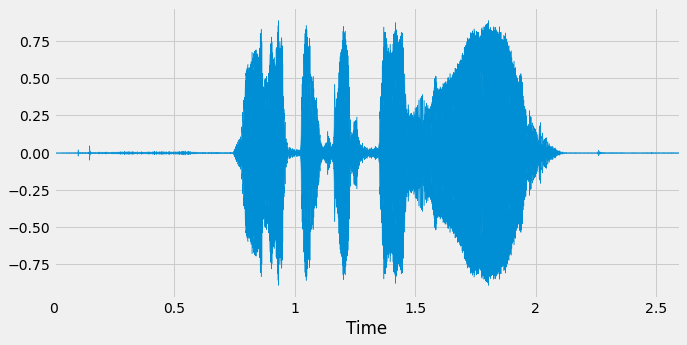

In [ ]:
# This sample is for Happy emotion
fname = dtsets_df._get_value(160, 'path')
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

/content/drive/MyDrive/DataSpeechs/Erzal/Recording_127.wav


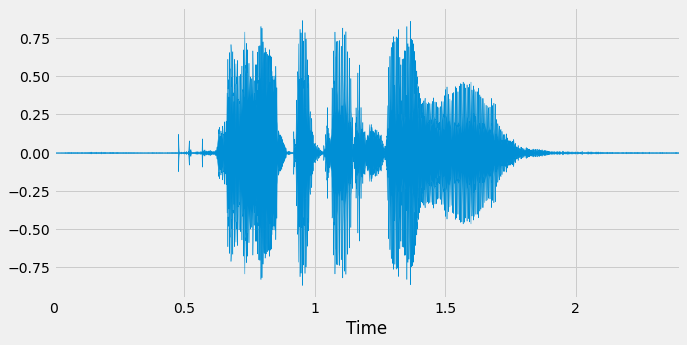

In [ ]:
# This sample is for Disappointed emotion
fname = dtsets_df._get_value(102, 'path')
print(fname)
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

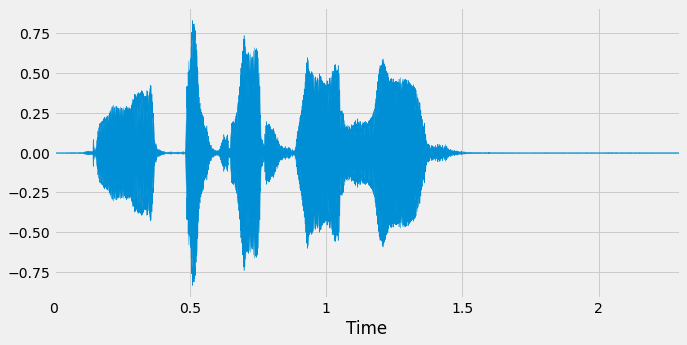

In [ ]:
# This sample is for Sad emotion
fname = dtsets_df._get_value(393, 'path')
#print(fname)
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

###Data Augmentation
<p align='justify'> To add variety to the dataset, data augmentation will be carried out. There are several types of augmentation data in speech processing, but in this project we will use augmentation data in the form of adding white noise and making changes to the speed and pitch of speech data.
It is hoped that this augmentation data will increase the quality of the model during the training process. </p>

In [62]:
def noise(signal):
  """
  Adding White Noise.
  """
  #signal, s_rate = lbr.load(wav, duration=2, sr=None)
  noise_amp = 0.01*np.random.uniform()*np.amax(signal)   # more noise reduce the value to 0.5
  signal = signal + noise_amp * np.random.normal(size=signal.shape[0])
  return signal

def speedNpitch(signal):
  """
  Speed and Pitch Tuning.
  """
  #signal, s_rate = lbr.load(wav, duration=2, sr=None)
  length_change = np.random.uniform(low=0.8, high = 1)
  speed_fac = 1.2  / length_change
  tmp = np.interp(np.arange(0, len(signal), speed_fac), np.arange(0, len(signal)), signal)
  minlen = min(signal.shape[0], tmp.shape[0])
  signal *= 0
  signal[0:minlen] = tmp[0:minlen]
  return signal

## Linear Predictive Coding (LPC)
<p align='justify'> LPC is one of the most powerful speech analysis techniques and it has gained popularity as a formant estimation technique. </p>
The stages of feature extraction in LPC:<br/>
1. Pre-Emphasis </br>
Pre-Emphasize is a filter that will process the speech signal so that the feature frequency of the speech data is maintained on the spectrum and keeps the speech data vulnerable to precision effects.</br>
2. Frame Blocking </br>
Frame blocking procedure consists  essentially  dividing the speech signal into short frames of N samples, which overlap by M samples, with adjacent frames.</br>
3. Windowing </br>
Windowing is used to minimize spectral distortion when blocking speech signals, each frame is multiplied by Hamming or Hann windowing.</br>
4. Autocorrelation </br>
5. LPC Analysis</br>

In [99]:
def LPC_feature(signal, order=16):
  # Define list for store LPF Features
  lpc_features = []

  # Read speech signal
  #signal, s_rate = librosa.load(wav, duration=2, sr=None)

  # Pre-Emphasis
  #emphasized_signal = librosa.effects.preemphasis(signal, coef=0.97)
  coeff = 0.97
  emphasized_signal = np.append(signal[0], signal[1:] - coeff * signal[:-1]) # Pre-Emphasis filter in Math form: y[n] = x[n] - a*x[n-1]

  # Frame Blocking and Windowing
  frames_win = np.abs(librosa.stft(emphasized_signal)) # using kind of Hann window
  idx_frame = len(frames_win)//2
  frames_win = frames_win[idx_frame]

  # Autocorrelation
  autocorrelation = sig.fftconvolve(frames_win, frames_win[::-1])
  #autocorrelation = sig.fftconvolve(emphasized_signal, emphasized_signal[::-1])
  autocorr_coeff = autocorrelation[autocorrelation.size//2:][:(order + 1)]      # Autocorrelation Coefficients

  # LPC features
  lpc_coeff_ld = lazy_lpc.levinson_durbin(autocorr_coeff, 16)
  lpc_features = lpc_coeff_ld.numerator[1:]
  
  return lpc_features

In [ ]:
# Checks whether the feature extraction function is successful or not
LPC_feature('/content/drive/MyDrive/Dataset TA/NewDataPrimer/Bahagia/Aka Bahagia 1.wav')

[-0.7829142527164893, 0.22879898045536368, -0.2182504896685117]

##Features Engineering
<p align='justify'> Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy. Feature engineering is required when working with machine learning models. Regardless of the data or architecture, a terrible feature will have a direct impact on your model.</p>
[source:https://towardsdatascience.com/]
<p align='justify'> The method used in this process is Linear Predictive Coding (LPC). We'll be using the LPC function we created earlier. </p>


In [55]:
from tqdm import tqdm

In [100]:
# Variable to store the extraction results
speech_features = pd.DataFrame(columns=['feature'])
noise_features = pd.DataFrame(columns=['feature'])
speedNpitch_features = pd.DataFrame(columns=['feature'])

cnt = 0 # Count variable for the feature extraction process

for wav_path in tqdm(dtsets_df.path):
  #print(wav_path)
  
  # Read data speech using Librosa
  signal, s_rate = librosa.load(wav_path, duration=2, sr=None)

  # Feature extraction for original speech
  lpcf = LPC_feature(signal)
  speech_features.loc[cnt] = [lpcf]

  # Feature extraction for white noise's augmentation
  aug = noise(signal)
  nf = LPC_feature(aug)
  noise_features.loc[cnt] = [nf]

  # Feature extraction for speed and pitch's augmentation
  aug = speedNpitch(signal)
  sNp = LPC_feature(aug)
  speedNpitch_features.loc[cnt] = [sNp]

  cnt += 1

100%|██████████| 400/400 [00:52<00:00,  7.67it/s]


In [101]:
# Check the extraction results
speech_features.head()

,feature
0,"[-0.7580745380662082, 0.2830136990574444, -0.2..."
1,"[-1.0706264477077647, 0.5881631331975049, -0.2..."
2,"[-1.1597496851688844, 0.7612603008380509, -0.5..."
3,"[-1.2230510135474277, 0.7396217642262025, -0.2..."
4,"[-1.2069498860650967, 1.0361879011767106, -0.8..."


In [102]:
# Check the extraction results
noise_features.head()

,feature
0,"[-0.7626702444545541, 0.3014744189503966, -0.2..."
1,"[-1.0440565885270614, 0.5409166785393652, -0.2..."
2,"[-1.2122881945706474, 0.7990307523652175, -0.5..."
3,"[-1.2323315658695333, 0.7185888210567345, -0.1..."
4,"[-1.1668618258735974, 0.9488495754037638, -0.7..."


In [103]:
# Check the extraction results
speedNpitch_features.head()

,feature
0,"[-0.7999947517482591, 0.2262119096161687, -0.0..."
1,"[-1.050145503055159, 0.636458795405498, -0.457..."
2,"[-1.4907352502542057, 1.364002410548376, -1.07..."
3,"[-0.9998550627450999, 0.49290854722690425, -0...."
4,"[-0.44189885328924783, -0.30885892345933386, -..."


In [104]:
# Combine features into the same dataframe
speech_features = pd.concat([dtsets_df, pd.DataFrame(speech_features['feature'].values.tolist())],axis=1)
noise_features = pd.concat([dtsets_df, pd.DataFrame(noise_features['feature'].values.tolist())],axis=1)
speedNpitch_features = pd.concat([dtsets_df, pd.DataFrame(speedNpitch_features['feature'].values.tolist())],axis=1)
print(speech_features.shape, noise_features.shape, speedNpitch_features.shape)

(400, 18) (400, 18) (400, 18)


In [105]:
dtsets_df = pd.concat([speech_features, noise_features, speedNpitch_features], axis=0, sort=False)
dtsets_df = dtsets_df.drop(['path'], axis=1)
dtsets_df = dtsets_df.fillna(0)

In [106]:
dtsets_df.head(-1)

,labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,bahagia,-0.758075,0.283014,-0.246204,0.083090,-0.015549,-0.017319,0.068359,-0.152100,0.213776,-0.525317,0.208674,-0.081976,0.056097,-0.091817,-0.029331,0.103107
1,bahagia,-1.070626,0.588163,-0.233059,-0.253219,0.103089,-0.145777,0.294284,-0.305064,0.345558,-0.238351,-0.150906,0.090757,-0.095520,0.199778,-0.131349,0.097039
2,bahagia,-1.159750,0.761260,-0.513124,0.205386,-0.256861,0.002129,0.109108,0.025736,-0.047276,0.059024,0.098435,-0.140024,-0.312488,0.382088,-0.294985,0.143182
3,bahagia,-1.223051,0.739622,-0.202758,-0.128800,0.050100,0.026345,-0.007980,-0.027532,-0.042868,0.145412,-0.351867,0.315298,-0.137120,-0.246686,0.392141,-0.203787
4,bahagia,-1.206950,1.036188,-0.882801,0.487466,-0.745703,0.751059,-0.598637,0.622403,-0.510864,0.507150,-0.320681,0.075364,-0.229664,0.336457,-0.514416,0.257721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,sedih,-1.110920,0.744276,-0.762022,0.626779,-0.491664,0.386558,-0.252342,0.133006,-0.172067,-0.318287,0.470695,-0.248425,0.142957,-0.111226,0.069253,-0.011543
395,sedih,-1.156251,0.465994,-0.164834,0.187291,-0.048303,-0.133642,-0.148511,0.037864,0.258090,-0.423788,0.449200,-0.325865,0.146978,-0.026809,0.075132,-0.105320
396,sedih,-1.164737,0.733099,-0.495970,0.419872,-0.321255,0.043998,0.037317,-0.166064,0.223400,-0.250444,0.275152,-0.299536,0.344555,-0.341941,0.354353,-0.287277
397,sedih,-1.825646,2.317569,-2.756138,2.399785,-1.620339,0.791179,0.020000,-0.590565,0.697331,-0.713319,0.614145,-0.513198,0.435387,-0.290553,0.245219,-0.137009


In [107]:
# Storing dataset feature
dtsets_df.to_csv('features16.csv')

In [108]:
# Separate variable predict and target
numeric_data = dtsets_df.select_dtypes(include=[np.number])
category_data = dtsets_df.select_dtypes(exclude=[np.number])
print(numeric_data.shape)
print(category_data.shape)

(1200, 16)
(1200, 1)


##K-Nearest Neighbor (K-NN)

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [110]:
audio_train, audio_test, label_train, label_test = train_test_split(numeric_data,
                                                    category_data,
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [111]:
lb = LabelEncoder()
lb.fit(label_train.values.ravel())

label_train = lb.transform(label_train.values.ravel())
label_test = lb.transform(label_test.values.ravel())

In [112]:
scaler = StandardScaler()
scaler.fit(audio_train)

audio_train = scaler.transform(audio_train)
audio_test = scaler.transform(audio_test)

In [117]:
test_skor = []
train_skor = []

for n in range(1, 17):
  knn = KNeighborsClassifier(n, weights='distance', algorithm='auto', metric='euclidean')
  knn.fit(audio_train, label_train)
  
  train_skor.append(knn.score(audio_train, label_train))
  test_skor.append(knn.score(audio_test, label_test))

In [118]:
maks_train_skor = max(train_skor)
train_skor_ind = [i for i, v in enumerate(train_skor) if v == maks_train_skor]
print('Nilai Maks Skor Variabel Prediktor {} % dengan k = {}'.format(maks_train_skor*100,list(map(lambda x: x+1, train_skor_ind))))

Nilai Maks Skor Variabel Prediktor 100.0 % dengan k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [119]:
maks_test_skor = max(test_skor)
test_skor_ind = [i for i, v in enumerate(test_skor) if v == maks_test_skor]
print('Nilai Maks Skor Variabel Target {} % dengan k = {}'.format(maks_test_skor*100,list(map(lambda x: x+1, test_skor_ind))))

Nilai Maks Skor Variabel Target 52.5 % dengan k = [1, 2]


Text(0, 0.5, 'Akurasi')

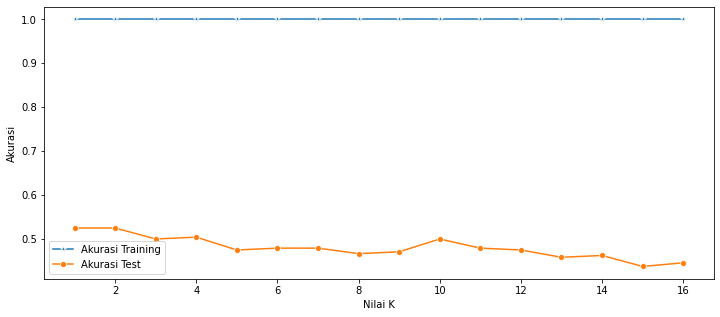

In [120]:
warnings.simplefilter(action="ignore", category=FutureWarning)
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1, 17),train_skor,marker='*',label='Akurasi Training')
p = sns.lineplot(range(1, 17),test_skor,marker='o',label='Akurasi Test')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi')

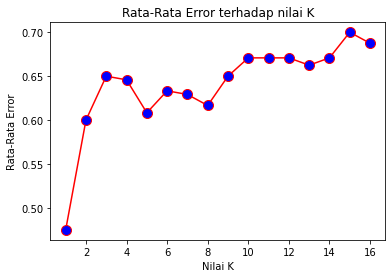

In [122]:
error = []

for i in range(1, 17):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(audio_train, label_train)
  pred_i = knn.predict(audio_test)
  error.append(np.mean(pred_i != label_test))

plt.figure()
plt.plot(range(1, 17), error, color='red', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Rata-Rata Error terhadap nilai K')
plt.xlabel('Nilai K')
plt.ylabel('Rata-Rata Error')
plt.show()

In [123]:
knn = KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='auto', metric='euclidean')
knn.fit(audio_train, label_train)
knn.score(audio_test, label_test)

0.525

In [124]:
knn_pred = knn.predict(audio_test)
print('Model accuracy: ', accuracy_score(label_test, knn_pred))

Model accuracy:  0.525


              precision    recall  f1-score   support

           0       0.56      0.52      0.54        58
           1       0.45      0.48      0.47        58
           2       0.53      0.51      0.52        61
           3       0.57      0.59      0.58        63

    accuracy                           0.53       240
   macro avg       0.53      0.52      0.52       240
weighted avg       0.53      0.53      0.53       240

---- Accuracy Score 52.5 -----



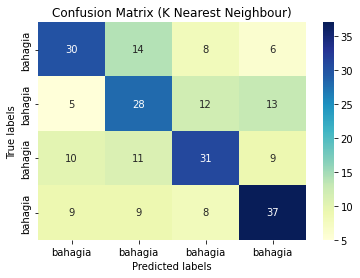

In [126]:
# Classification reports and Confusion Matrix

print(classification_report(label_test, knn_pred))

acc_knn = float(accuracy_score(label_test, knn_pred))*100
print("---- Accuracy Score %s -----" % acc_knn)
print('')

cm_knn = confusion_matrix(label_test,knn_pred)

ax= plt.subplot()
sns.heatmap(cm_knn, annot=True, cmap='YlGnBu', fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix (K Nearest Neighbour)'); 
ax.xaxis.set_ticklabels(emotions);
ax.yaxis.set_ticklabels(emotions);